In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from lmfit import minimize
from shapely import LineString
from scipy.integrate import simpson
from scipy.interpolate import interp1d

In [4]:
import pyroll.core as pr
import pyroll.pillar_model
import pyroll.neutral_point_estimator
import pyroll.sparling_spreading
import pyroll.hensel_force_torque
import pyroll.freiberg_flow_stress
import pyroll.ring_model_thermal

In [5]:
from in_profile import create_in_profile_from_surface_temperature
from rolling_sequence import roughing_sequence, intermediate_sequence, finishing_sequence

In [6]:
pyroll.pillar_model.Config.PILLAR_COUNT = 30
pyroll.neutral_point_estimator.Config.ESTIMATOR = "EQUAL"
ROLL_SURFACE_TEMPERATURE = 50 + 273.15
DISK_ELEMENT_COUNT = 30

In [7]:
@pr.CoolingPipe.DiskElement.heat_transfer_coefficient
def heat_transfer_coefficient_model_moreales(self: pr.CoolingPipe.DiskElement):
    mean_surface_temperature = (self.in_profile.surface_temperature - self.out_profile.surface_temperature) / 2

    if mean_surface_temperature <= 650 + 273.15:
        htc = 12.77 * np.exp(-0.00402 * mean_surface_temperature) * self.cooling_pipe.coolant_velocity ** 0.64
    else:
        w_coefficient = self.cooling_pipe.coolant_volume_flux * 1000 / self.cooling_pipe.coolant_flow_cross_section
        htc = 14.06 * w_coefficient ** 0.63 / (mean_surface_temperature - self.cooling_pipe.coolant_temperature)

    return htc * 1000

In [8]:
in_profile = create_in_profile_from_surface_temperature(1100 + 273.15)
in_profile.ring_temperatures = in_profile.ring_temperatures

In [9]:
roughing_train = roughing_sequence(
    roll_surface_temperature=ROLL_SURFACE_TEMPERATURE,
    disk_element_count=DISK_ELEMENT_COUNT
)

# intermediate_train = intermediate_sequence(
#     roll_surface_temperature=ROLL_SURFACE_TEMPERATURE,
#     disk_element_count=DISK_ELEMENT_COUNT
# )
#
# finishing_train = finishing_sequence(
#     roll_surface_temperature=ROLL_SURFACE_TEMPERATURE,
#     disk_element_count=DISK_ELEMENT_COUNT
# )


In [10]:
rolling_train = pr.PassSequence([
    roughing_train,
   # intermediate_train,
  #  finishing_train
])

In [11]:
rolling_train.flatten()

In [12]:
rolling_train.solve(in_profile)

/home/christoph/PycharmProjects/phd-thesis-fitting-wear-coefficient/.venv/lib/python3.13/site-packages/pyroll/pillar_model/roll_pass/hookimpls/pillar_disk_element.py:30: RuntimeWarning: invalid value encountered in divide
  return self.out_profile.pillar_heights / self.in_profile.pillar_heights


RuntimeError: Solution of sub units failed at unit TwoRollPass 'B'.

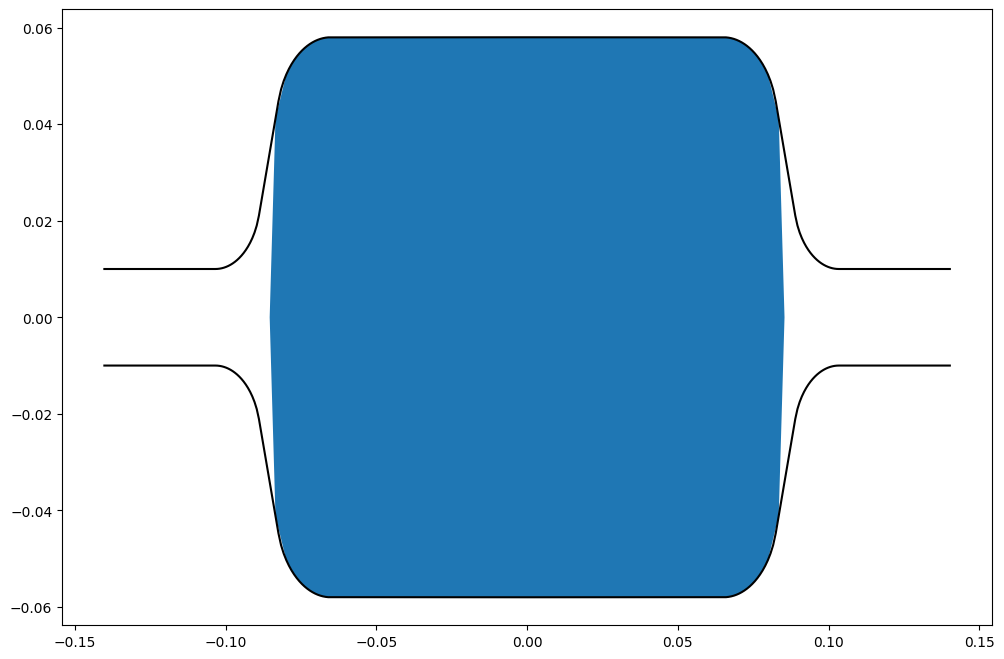

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
for roll_pass in roughing_train.roll_passes:
    for cl in roll_pass.contour_lines.geoms:
        ax.plot(*cl.xy, color="black")
    ax.fill(*roll_pass.out_profile.cross_section.boundary.xy)

In [ ]:
def pillar_deformation_resistance(roll_pass: pr.RollPass):
    from pyroll.freiberg_flow_stress import flow_stress
    pillars_flow_stress = flow_stress(roll_pass.out_profile.freiberg_flow_stress_coefficients,
                                      roll_pass.total_pillar_strains,
                                      roll_pass.total_pillar_strain_rates,
                                      roll_pass.out_profile.temperature)
    pillar_deformation_resistance = pillars_flow_stress / roll_pass.rolling_efficiency
    return pillar_deformation_resistance


def pillars_wear_length(roll: pr.RollPass.Roll) -> np.ndarray:
    local_roll_radii = np.concatenate(
        [roll.max_radius - roll.surface_interpolation(0, center)
         for center in roll.roll_pass.in_profile.pillars],
        axis=0).flatten()

    pillars_wear_length = np.zeros_like(roll.roll_pass.in_profile.pillars)

    for de in roll.roll_pass.disk_elements:
        horizontal_roll_velocities = local_roll_radii * roll.rotational_frequency * 2 * np.pi * np.cos(
            de.pillar_longitudinal_angles)
        for i, pillars in enumerate(de.in_profile.pillars):
            if de.pillar_velocities[i] < horizontal_roll_velocities[i] and de.pillars_in_contact[i]:
                pillars_wear_length[i] += de.length

    return pillars_wear_length


def extract_wear_contours_from_measurement():
    root_dir = Path.cwd()
    wear_data_dir = root_dir / "wear_data"

    labels = []
    tonnages = []
    measured_wear_contours = []

    for file in wear_data_dir.iterdir():
        with open(file, "r") as file:
            data = json.load(file)

        for entry in data["wear_data"]:
            labels.append(entry["groove"])
            tonnages.append(entry["tonnage"])
            x_values = np.array([point["x"] * 1e-3 for point in entry["wear_contour"]])
            y_values = np.array([point["y"] * 1e-3 for point in entry["wear_contour"]])
            x_values_shifted = x_values - max(x_values) / 2
            measured_wear_contour = LineString(list(zip(x_values_shifted, y_values)))
            measured_wear_contours.append(measured_wear_contour)

        return labels, tonnages, measured_wear_contours


def calculate_area_between_contours(contour_1: LineString, contour_2: LineString):
    z1, y1 = contour_1.xy
    z2, y2 = contour_2.xy
    z_min = max(min(z1), min(z2))
    z_max = min(max(z1), max(z2))
    z_common = np.linspace(z_min, z_max, 1000)

    f1 = interp1d(z1, y1, kind='linear', fill_value='extrapolate')
    f2 = interp1d(z2, y2, kind='linear', fill_value='extrapolate')

    y1_interp = f1(z_common)
    y2_interp = f2(z_common)

    diff = np.abs(y1_interp - y2_interp)
    area = simpson(diff, z_common)

    return area


def root_mean_square_value(error_array: np.array) -> float:
    return np.sqrt(np.mean(error_array ** 2))


def calculate_wear_contour(roll_pass: pr.RollPass, wear_coefficient: float, tonnage: float):
    vickers_hardness_c15c = 900

    pillars_wear_length = pillars_wear_length(roll_pass.roll)
    pillar_deformation_resistance = pillar_deformation_resistance(roll_pass)
    pillar_wear_depths = wear_coefficient * pillar_deformation_resistance * pillars_wear_length / (
            3 * vickers_hardness_c15c)
    total_pillar_wear_depths = pillar_wear_depths * tonnage / roll_pass.in_profile.weight
    wear_depths_with_groove_contour = roll_pass.roll.groove.local_depth(
        roll_pass.out_profile.pillars) + total_pillar_wear_depths
    right_side = list(zip(roll_pass.out_profile.pillars, wear_depths_with_groove_contour))
    left_side = list(zip(-roll_pass.out_profile.pillars[::-1], wear_depths_with_groove_contour[::-1]))
    combined_contour_list = left_side + right_side
    wear_contours.append(LineString(combined_contour_list))

    return wear_contours

In [ ]:
def solve_total_wear_depths_as_contour_line(wear_coefficient: float):
    roll_passes = rolling_train.roll_passes
    area_errors = []

    for roll_pass in roll_passes:
        labels, tonnages, measured_wear_contours = extract_wear_contours_from_measurement()
        for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
            if roll_pass.label == labels:
                calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                area_errors.append(area_error)

    rms_error = root_mean_square_value(np.array(area_errors))



In [ ]:
# try:
#     result = minimize(
#         solve_total_wear_depths_as_contour_line,
#         params,
#         nan_policy='omit',
#         max_nfev=100,
#         args=(cases, solver),
#         method="cobyla"
#     )
#     return extract_modifications(result.params)
# except Exception as e:
#     print(f"Optimization failed: {e}")
#     return None


In [ ]:
def compare_groove_contour_to_wear_contour(sequence: pr.PassSequence, roll_pass_label: str):
    for roll_pass in sequence.roll_passes:
        if roll_pass.label == roll_pass_label:
            groove = roll_pass.roll.groove

    labels, tonnages, measured_wear_contours = extract_wear_contours_from_measurement(roll_pass_label)

    areas_between_contours = []
    for contour in measured_wear_contours:
        area = calculate_area_between_contours(contour, groove.contour_line)
        areas_between_contours.append(area)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title("Groove Contour Comparison")
    ax.plot(*groove.contour_line.xy)
    for contour, tonnage, label, area in zip(measured_wear_contours, tonnages, labels, areas_between_contours):
        ax.plot(*contour.xy, label=f"{label} - {tonnage}")
        print(f"Area between original groove and wear contour after {tonnage} tons: {area * 1e6:.6e} mm²")
    ax.set_xlabel("z [m]")
    ax.set_ylabel("y [m]")
    ax.set_aspect("equal")
    ax.legend()
    ax.grid(True)

    return np.array(areas_between_contours)